# 2 Probability, Entropy, and Inference

## Definition of entropy and related functions

**The Shannon information content of an outcome $x$**
$$h\left(x\right) = \mathrm{log}_2\frac{1}{P\left(x\right)}$$
It is measured in bits. The Shannon information content is a natural measure of the information content of the event $x=a_i$.

In Python, this might look something like the following:

In [1]:
import math

def shannon_information(probability, base=2):
    return -math.log(probability)/math.log(base)

shannon_information(0.0008)

10.287712379549449

An implementation of this metrics can be found in the module ```shannon.py``` and will be used like the following:

In [2]:
from entropy_lab.measures.shannon import shannon_information

shannon_information(0.0008)

10.287712379549449

**How Surprising are Electricity Prices?**

To illustrate the power and intuitiveness of the Shannon Information content, we will here do a small data analysis, in which the development on the spot markets for 'day ahead' prices of electricity is computed in light of this measure. 

We will use the Shannon Information as a suprirse meter for extreme price events.

In [3]:
import pandas as pd

df = pd.read_csv("/Users/fdolci/projects/entropy_lab/data/ogd106_preise_strom_boerse.csv")
df.columns = ["date", "price"]
df.head()

,date,price
0,2017-01-01,48
1,2017-01-02,58
2,2017-01-03,69
3,2017-01-04,65
4,2017-01-05,63


In [4]:
# Some data cleaning
df = df.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna(subset=["date", "price"]).sort_values("date")
df.head()

,date,price
0,2017-01-01,48
1,2017-01-02,58
2,2017-01-03,69
3,2017-01-04,65
4,2017-01-05,63


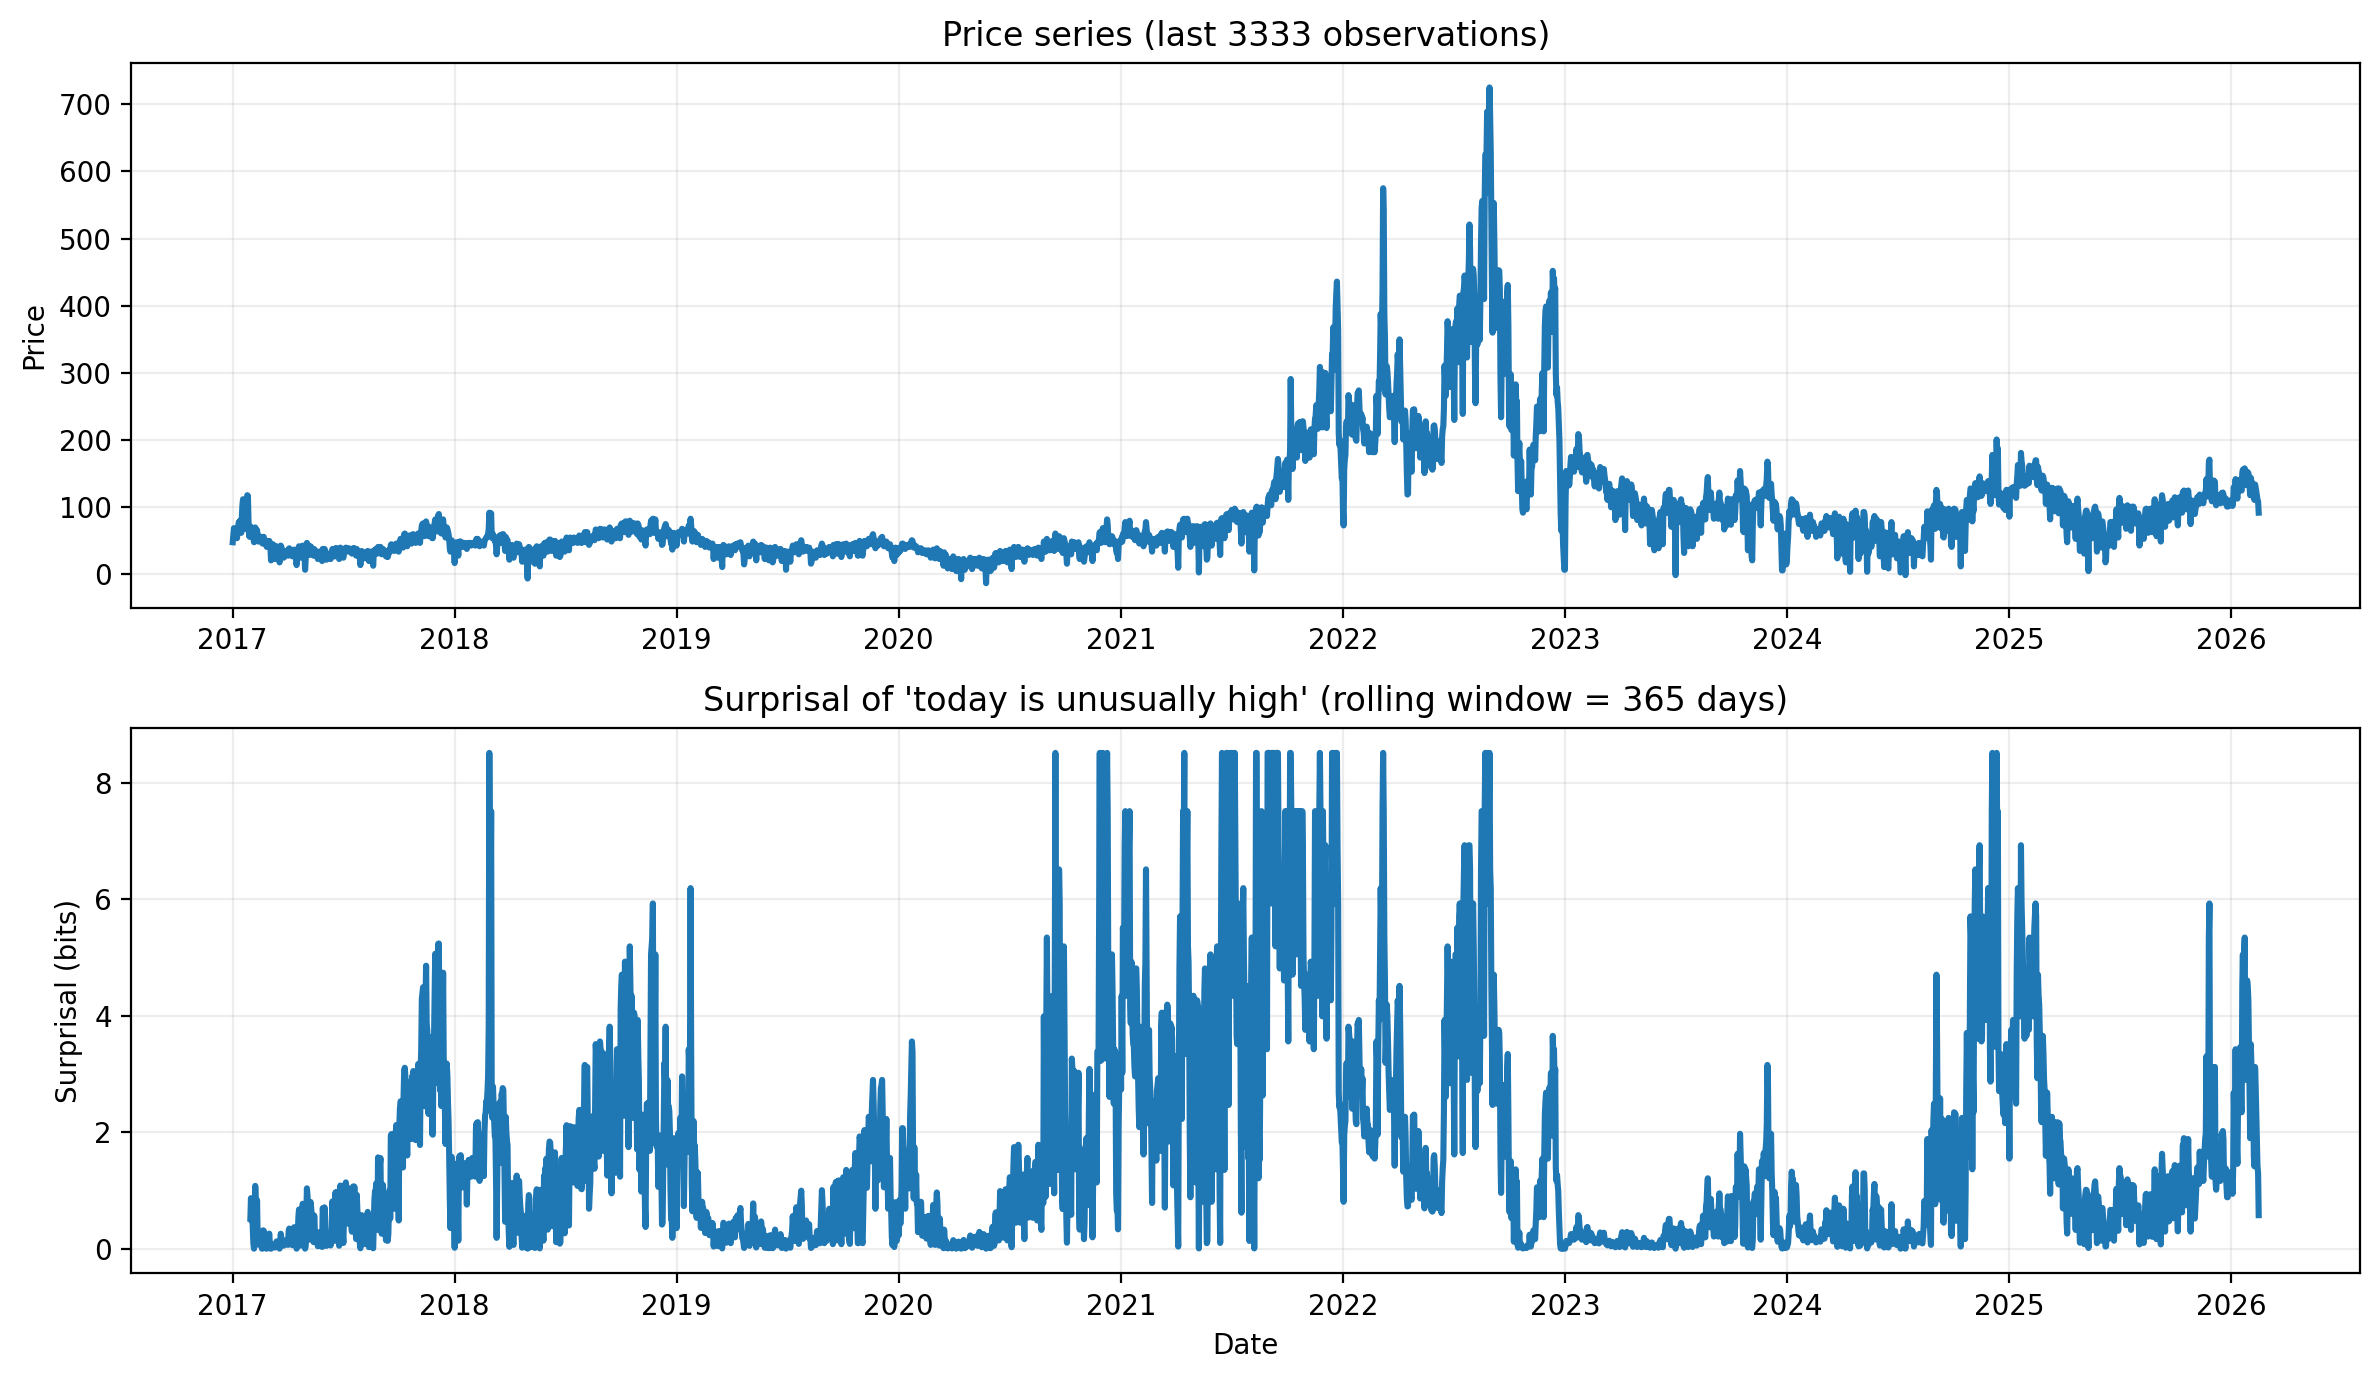

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from entropy_lab.measures.shannon import shannon_information

window = 365          # days 
min_periods = 30    
eps = 1e-6           # avoid p=0 => infinite

prices = df["price"].to_numpy()

p_tail = np.full(len(df), np.nan, dtype=float)

for i in range(len(df)):
    start = max(0, i - window + 1)
    w = prices[start:i+1]
    if len(w) < min_periods:
        continue
    # empirical upper-tail probability: P(price >= today's price)
    p = np.mean(w >= prices[i])
    p_tail[i] = max(p, eps)

df["p_upper_tail"] = p_tail
df["surprisal_bits"] = df["p_upper_tail"].apply(
    lambda p: shannon_information(float(p), base=2.0) if np.isfinite(p) else np.nan
)

fig = plt.figure(figsize=(12, 7), dpi=200)

ax1 = fig.add_subplot(211)
ax1.plot(df["date"], df["price"], linewidth=2.2)
ax1.set_title(f"Price series (last {len(df)} observations)")
ax1.set_ylabel("Price")
ax1.grid(True, alpha=0.22)

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(df["date"], df["surprisal_bits"], linewidth=2.2)
ax2.set_title(f"Surprisal of 'today is unusually high' (rolling window = {window} days)")
ax2.set_ylabel("Surprisal (bits)")
ax2.set_xlabel("Date")
ax2.grid(True, alpha=0.22)

plt.tight_layout()
plt.show()

**The entropy of an ensemble $X$** 

This measure is defined as being the average Shannon information content of an outcome:
$$H\left(X\right) = \sum_{x\in\mathcal{A}_{X}} P\left(x\right) \log\frac{1}{P\left(x\right)} \quad \quad [\mathrm{bits}]$$

Another name for the entropy of $X$ is the *uncertainty* of $X$.

We can compute the entropy of a random variable $X$ using the Shannon Information content, as defined earlier, and we thus can write the following code:

In [6]:
from entropy_lab.measures.shannon import shannon_information
import numpy as np
import numpy.typing as npt

def compute_entropy(p: npt.NDArray[np.floating], base = 2.0) -> float: 
    h = 0
    for x in p:
        h += x * shannon_information(x, base)
    return h

We can now use our custom-made entropy function the following way:

In [7]:
import numpy as np
from scipy.stats import entropy
from entropy_lab.measures.entropy import compute_entropy

example_array = np.array([0.1, 0.4, 0.5])
compute_entropy(example_array)

np.float64(1.360964047443681)

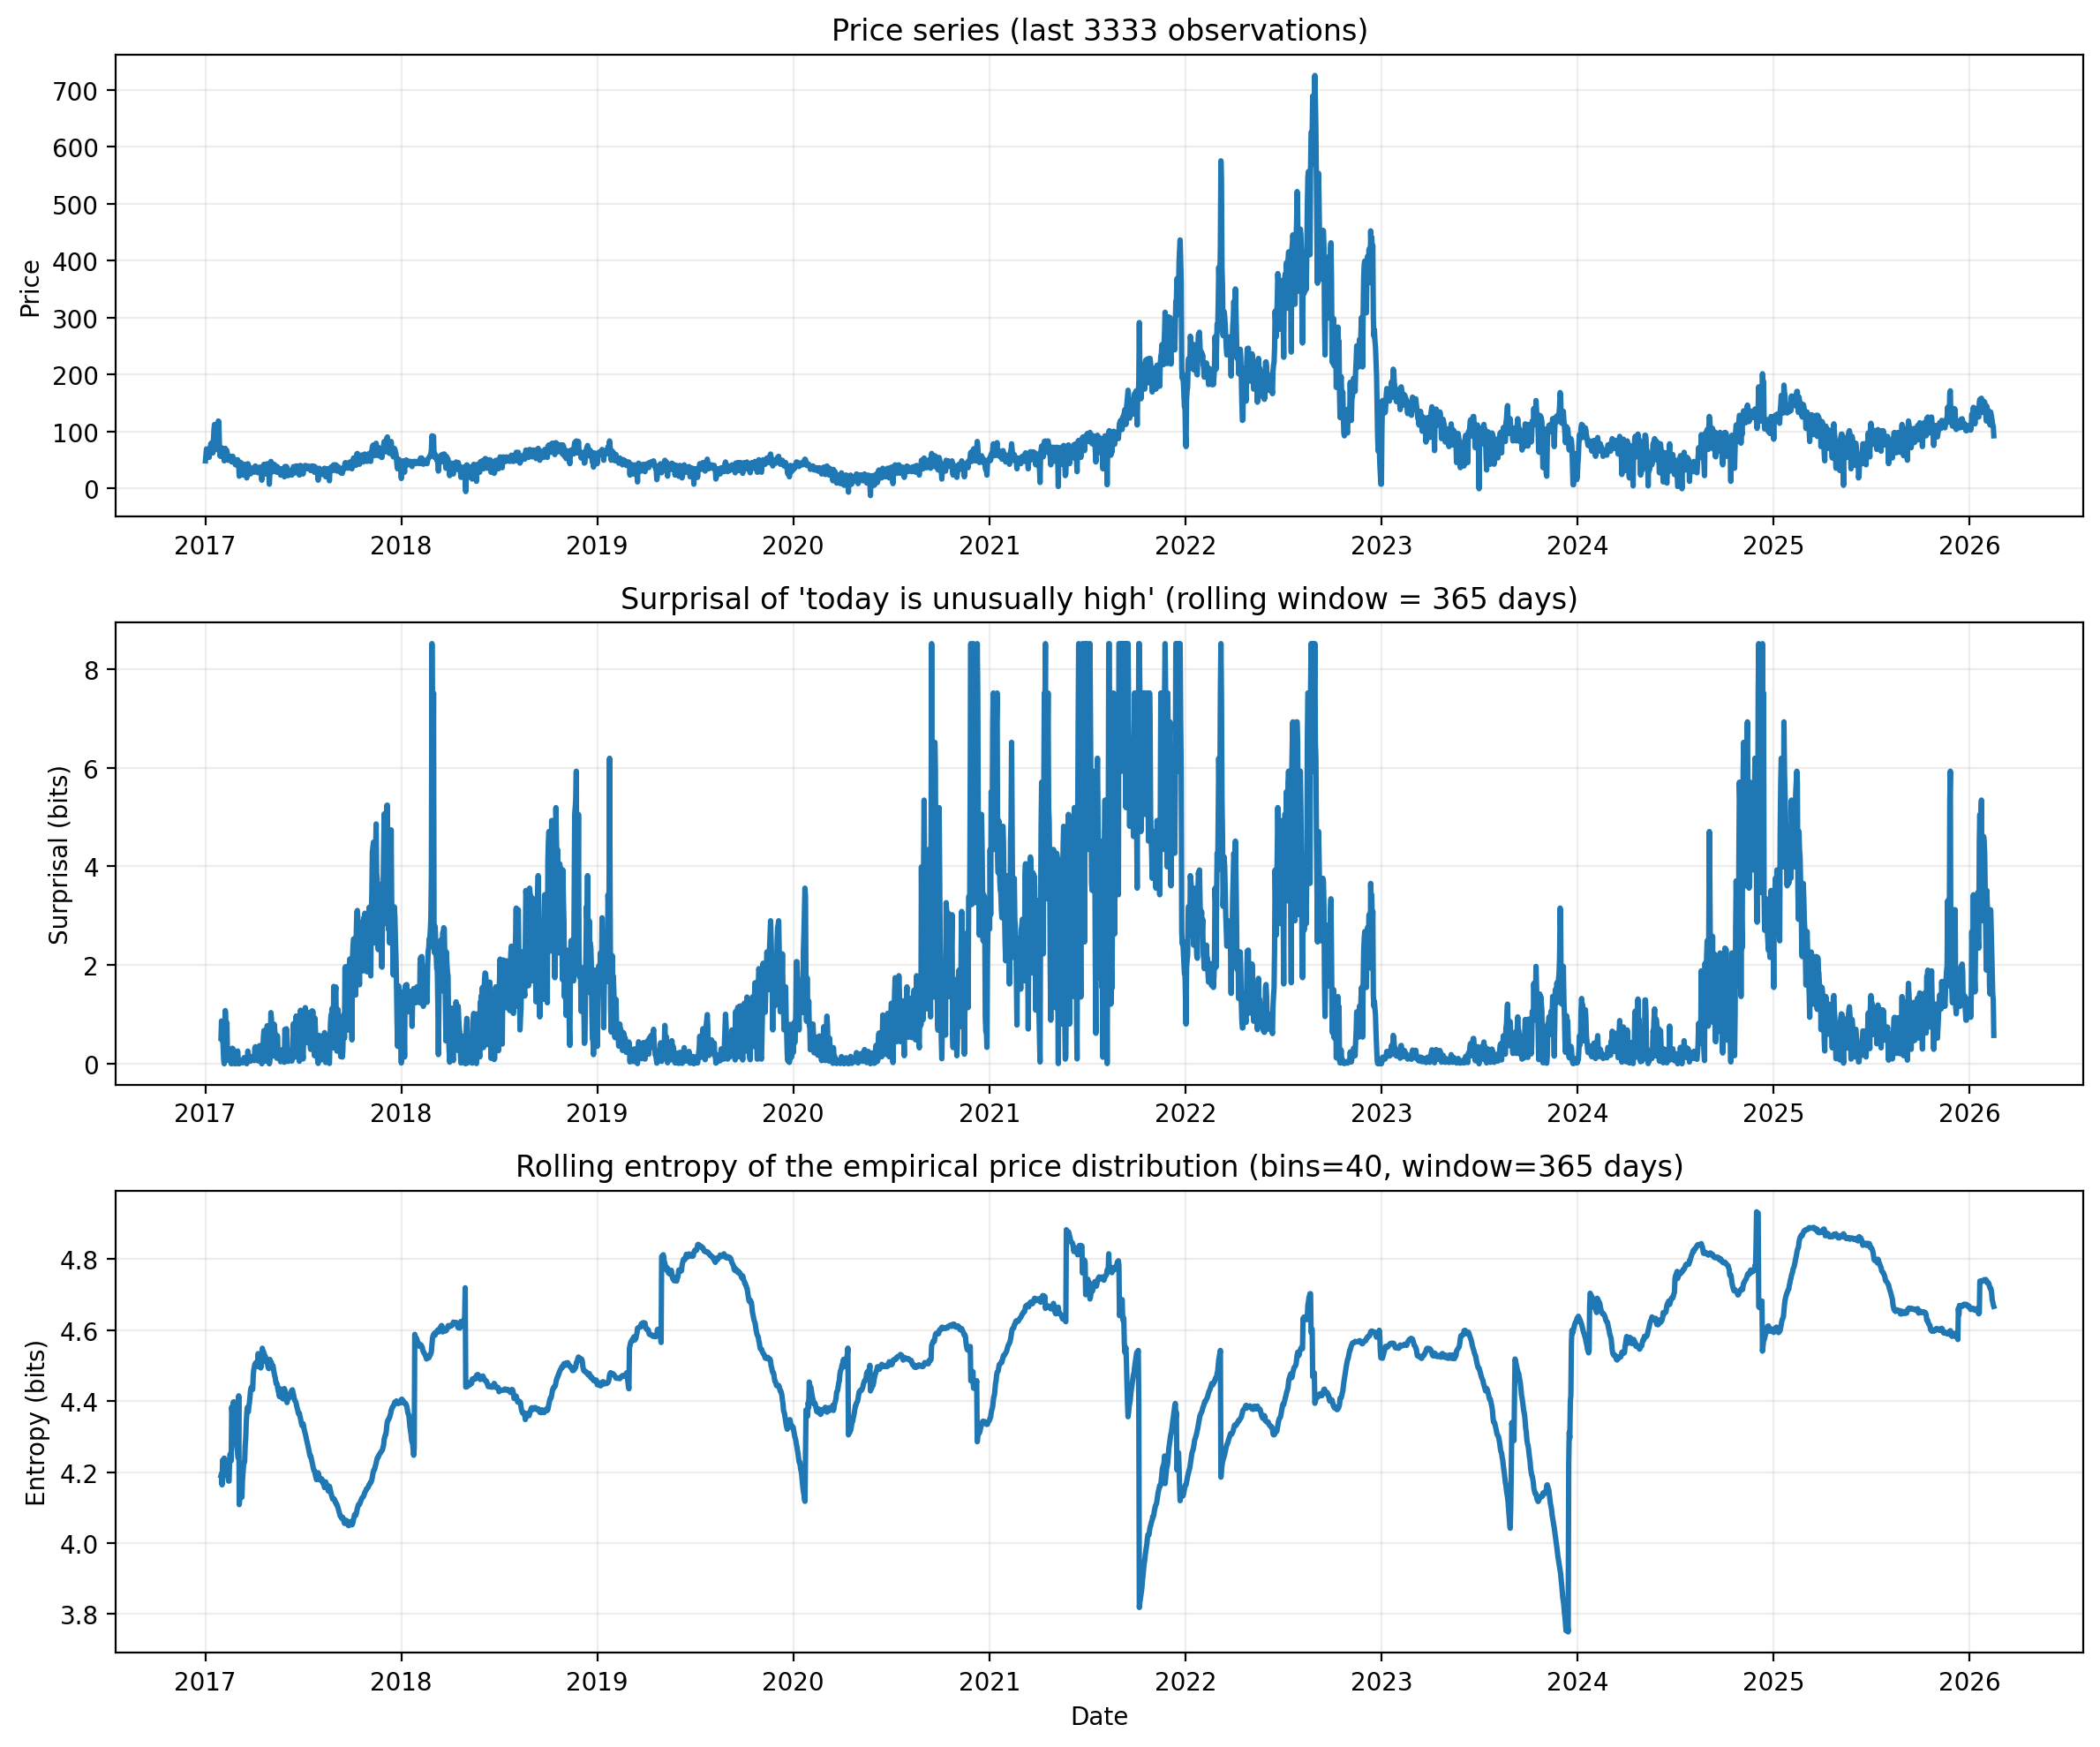

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from entropy_lab.measures.entropy import compute_entropy

window = 365
min_periods = 30
bins = 40                 # keep fixed for comparability
eps = 1e-12               # avoid log(0)

prices = df["price"].to_numpy()
H_roll = np.full(len(df), np.nan, dtype=float)

for i in range(len(df)):
    start = max(0, i - window + 1)
    w = prices[start:i+1]
    if len(w) < min_periods:
        continue

    # histogram -> pmf
    counts, _ = np.histogram(w, bins=bins)
    pmf = counts.astype(float) / max(counts.sum(), 1.0)
    pmf = np.clip(pmf, eps, 1.0)          # numerical safety
    pmf = pmf / pmf.sum()

    H_roll[i] = entropy(pmf, base=2.0)

df["entropy_bits"] = H_roll

fig = plt.figure(figsize=(12, 10), dpi=200)

ax1 = fig.add_subplot(311)
ax1.plot(df["date"], df["price"], linewidth=2.2)
ax1.set_title(f"Price series (last {len(df)} observations)")
ax1.set_ylabel("Price")
ax1.grid(True, alpha=0.22)

ax2 = fig.add_subplot(312, sharex=ax1)
ax2.plot(df["date"], df["surprisal_bits"], linewidth=2.2)
ax2.set_title(f"Surprisal of 'today is unusually high' (rolling window = {window} days)")
ax2.set_ylabel("Surprisal (bits)")
ax2.grid(True, alpha=0.22)

ax3 = fig.add_subplot(313, sharex=ax1)
ax3.plot(df["date"], df["entropy_bits"], linewidth=2.2)
ax3.set_title(f"Rolling entropy of the empirical price distribution (bins={bins}, window={window} days)")
ax3.set_ylabel("Entropy (bits)")
ax3.set_xlabel("Date")
ax3.grid(True, alpha=0.22)

plt.tight_layout()
plt.show()


**Some properties of the entropy**

* $H\left(X\right) \geq 0$ with equality iff $p_i = 1$ for one $i$.
* Entropy is maximized if $\mathbf{p}$ is uniform: $H\left(X\right) \leq \log\left(|\mathcal{A}_X|\right)$ with equality iff $p_i=1/|\mathcal{A}_X|$ for all $i$.

**The joint entropy of $X, Y$**

$$H\left(X,Y\right) = \sum_{xy\in\mathcal{A}_X\mathcal{A}_Y}P\left(x,y\right)\log\frac{1}{P\left(x,y\right)}$$

Using Python, one can compute the joint entropy in the folliwng way:

In [9]:
import numpy as np
from entropy_lab.measures.entropy import compute_entropy

# Joint probability distribution example, must sum to 1
p_xy = np.array([
    [0.30, 0.20],
    [0.10, 0.20],
    [0.05, 0.15]
]) 
compute_entropy(p_xy.ravel(), base=2.0, normalize=False)

np.float64(2.408694969562842)

Using the custome-made function in the ```entropy``` script:

In [10]:
import numpy as np
from entropy_lab.measures.entropy import compute_joint_entropy

p_xy = np.array([
    [0.30, 0.20],
    [0.10, 0.20],
    [0.05, 0.15]
]) 
compute_joint_entropy(p_xy)

np.float64(2.408694969562842)

For an illustrative example of the joint entropy (and its link to the information - theory comes later), you can have a look at the experiment notebook ```medical_screening_test.py```. 

## Gibbs' inequality

**The relative entropy *or* Kullback-Leibler divergence** between two probability distributions $P\left(x\right)$ and $Q\left(x\right)$ that are defined over the same alphabet $\mathcal{A}_X$ is

$$D_{\mathrm{KL}}\left(P||Q\right) = \sum_xP\left(x\right)\log\frac{P\left(x\right)}{Q\left(x\right)}$$

and satisfies Gibbs' inequality:

$$D_{\mathrm{KL}}\left(P||Q\right) \geq 0$$

Note that the relative entropy is not symmetric, i.e., $D_{\mathrm{KL}}\left(P||Q\right) \neq D_{\mathrm{KL}}\left(Q||P\right)$. It is one of the most import inequality in the field of information theory and machine learning, and is used to compare two probability distributions (although it is not stricltly speaking a distance).

We can compute this value using Python in the following way:

In [11]:
import numpy as np

base = 2
p = np.array([0.5, 0.3, 0.2])
q = np.array([0.4, 0.4, 0.2])

d_pq = np.sum(p * (np.log(p / q) / np.log(base)))
d_pq

np.float64(0.03645279766002797)

We can verify our simple implementation by using ```scipy```function:

In [12]:
from scipy.stats import entropy

entropy(pk=p, qk=q, base=base)

np.float64(0.036452797660027965)

We developped our own implementation of this function and it can be found in the ```entropy.py``` script.

In [13]:
from entropy_lab.measures.entropy import compute_kl_divergence

compute_kl_divergence(p, q, base)

np.float64(0.03645279766002797)

An example of the use of the KL divergence can be found in the electricity playground notebook. 